# S1 Conditional GAN

As mentioned before, s1 and s2 are important characteristics to correctly model. Therefore the following script will create a conditional GAN, using s1 for dark matter at 50KeV and 200KeV

In [1]:
pip install uproot

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd gdrive/My\ Drive/test_run

/content/gdrive/My Drive/test_run


Here we will extract some root files, most will be used to train the GAN, then one will be used to 'validate' the GAN.

Currently, we will use 50, 150, and 250 to train and 100 and 200 to validate.

In [0]:
import uproot
import pandas
import matplotlib.pyplot as plt
import numpy as np

tree50 = uproot.open("darkmatter_test_run_v5.root")["dstree"]
tree100 = uproot.open("darkmatter_test_run_v7.root")["dstree"]
tree150 = uproot.open("darkmatter_test_run_v8.root")["dstree"]
tree200 = uproot.open("darkmatter_test_run_v6.root")["dstree"]
tree250 = uproot.open("darkmatter_test_run_v9.root")["dstree"]

The Variable is input here to try to make the code reusable and as general as possible.

In [0]:
#VARIABLE
var = "s1ene"

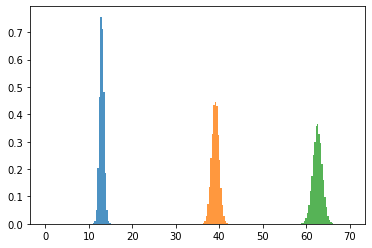

In [6]:

train_DS_ene_50 = np.array(tree50.array(f"{var}"))
train_DS_ene_100 = np.array(tree100.array(f"{var}"))
train_DS_ene_150 = np.array(tree150.array(f"{var}"))
train_DS_ene_200 = np.array(tree200.array(f"{var}"))
train_DS_ene_250 = np.array(tree250.array(f"{var}"))

e_50 = plt.hist(train_DS_ene_50,range = (0,70), density = True, bins = 205, alpha = 0.8)
e_150 = plt.hist(train_DS_ene_150,range = (0,70), density = True, bins = 205, alpha = 0.8)
e_250 = plt.hist(train_DS_ene_250,range = (0,70), density = True, bins = 205, alpha = 0.8)


In [0]:
num_train = int(1e5)
noise_size = 100

# Length needs to be followed through
train_var = [50., 150., 250.]

In [8]:
from keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU, Concatenate
from keras.models     import Model, Sequential
from keras.optimizers import Adam, SGD

import keras.backend as K
d_do = 0.2
d_nodes = 70
#Input of GEN VALUE
d1_in = Input((1,))
d1 = Dense(d_nodes, activation="relu")(d1_in)
d1 = Dropout(d_do)(d1)

#Input of parameter = energy
hyper_in = Input((1,))
d2 = Dense(d_nodes, activation="relu")(hyper_in)
d2 = Dropout(d_do)(d2)

dc = Concatenate()([d1, d2])
dc = Dense(d_nodes , activation="relu")(dc)
dc = Dropout(d_do)(dc)
dc = Dense(d_nodes , activation="relu")(dc)
dc = Dropout(d_do)(dc)
dc = Dense(d_nodes , activation="relu")(dc)
dc = LeakyReLU(0.2)(dc)
dc = Dropout(d_do)(dc)
dc = Dense(2, activation="softmax")(dc)

dc = Model(name="Discriminator", inputs=[d1_in, hyper_in], outputs=[dc])
dc.compile(loss="categorical_crossentropy", optimizer=Adam(0.0005, beta_1=0.3), metrics=["accuracy"])
# 0.0005, beta_1=0.5
dc.summary()

#INPUT OF NOISE TO GENERATOR
g1_in = Input((noise_size,))
g1 = Dense(50, activation="relu")(g1_in)
g1 = Dropout(0.2)(g1)
g1 = BatchNormalization()(g1)
g1 = Dense(50, activation="relu")(g1)

#INPUT OF HYPERPARAM
g2 = Dense(50, activation="relu")(hyper_in)

gc = Concatenate()([g1, g2])
gc = BatchNormalization()(gc)
gc = Dropout(0.2)(gc)
gc = Dense(50, activation="relu")(gc)
gc = Dropout(0.2)(gc)
g1 = Dense(50, activation="relu")(g1)
gc = Dense(1, activation="linear")(gc)

gc = Model(name="Generator", inputs=[g1_in, hyper_in], outputs=[gc])
gc.summary()


gan_out = dc([gc([g1_in, hyper_in]), hyper_in])
gan = Model([g1_in, hyper_in], gan_out, name="GAN")
dc.trainable = False
gan.compile(loss="categorical_crossentropy", optimizer=Adam(0.0005, beta_1=0.3), metrics=["accuracy"])
gan.summary()

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 70)           140         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 70)           140        

In [0]:
#  Train GAN

epochs     = 1000
batch_size = 100
rel_batch_size = 1
max_D_itrs_per_G_itr_e80 = 2
max_D_itrs_per_G_itr_e52 = 3

In [0]:
def plot_points_GAN (gen_data, train_data, epoch, batch_size, d_acc) :

    #Needs to be changed depending on number of examples
    gen_class_length = int(gen_data.shape[0]/3)
    gen_data_1 = gen_data[:gen_class_length                    ,0]
    gen_data_2 = gen_data[gen_class_length  :2*gen_class_length,0]
    gen_data_3 = gen_data[2*gen_class_length:3*gen_class_length,0]
    tr_class_length = int(train_data.shape[0]/3)
    train_data_1 = train_data[:tr_class_length                   ,0]
    train_data_2 = train_data[tr_class_length  :2*tr_class_length,0]
    train_data_3 = train_data[2*tr_class_length:3*tr_class_length,0]


    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(1, 2, 1)
    h0 = plt.hist(gen_data_115, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="blue"  , density=True, label=r"Generated data ($var="+f"{train_var[0]:.0f}"+r"~{\rm KeV}$)")
    h1 = plt.hist(gen_data_130, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="purple", density=True, label=r"Generated data ($var="+f"{train_var[1]:.0f}"+r"~{\rm KeV}$)")
    h2 = plt.hist(gen_data_145, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="red"   , density=True, label=r"Generated data ($var="+f"{train_var[2]:.0f}"+r"~{\rm KeV}$)")
    plt.legend(loc="upper right", fontsize=10)
    plt.xlabel("x", size=14, labelpad=10)
    plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
    plt.gca().set_xlim([range_min-0.1*range_width, range_max+0.1*range_width])
    #y_max = 1.5*np.max([max(h0[0]), max(h1[0]), max(h2[0])])
    y_max = 1
    if np.isnan(y_max) : y_max = 1.0
    plt.gca().set_ylim([0, y_max])
    plt.text(range_min+0.*1.1*range_width   , 0.88*y_max, "Conditional", size=14, style="italic", weight="bold")
    plt.text(range_min+0.*1.1*range_width   , 0.80*y_max, "GAN test", size=18, style="italic", weight="bold")
    plt.text(range_min+0.780*1.1*range_width, 0.68*y_max, f"Epoch: {epoch}")
    plt.text(range_min+0.713*1.1*range_width, 0.61*y_max, f"Batch size: {gen_class_length}")
    plt.text(range_min+0.810*1.1*range_width, 0.54*y_max, r"$\epsilon_{\rm disc}$: "+f"{int(100.*d_acc)}%")
    plt.subplots_adjust(left=0.18, right=0.98, top=0.95, bottom=0.15)
    fig.add_subplot(1, 2, 2)
    h0_2 = plt.hist(train_data_115, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="blue"  , density=True, label=r"Training data ($m="+f"{train_var[0]:.0f}"+r"~{\rm GeV}$)")
    h1_2 = plt.hist(train_data_130, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="purple", density=True, label=r"Training data ($m="+f"{train_var[1]:.0f}"+r"~{\rm GeV}$)")
    h2_2 = plt.hist(train_data_145, bins=np.linspace(range_min, range_max, 1+int(range_width/plot_resolution)), color="red"   , density=True, label=r"Training data ($m="+f"{train_var[2]:.0f}"+r"~{\rm GeV}$)")
    plt.legend(loc="upper right", fontsize=10)
    plt.xlabel("x", size=14, labelpad=10)
    plt.gca().set_xlim([range_min-0.1*range_width, range_max+0.1*range_width])
    #y_max = 1.5*np.max([max(h0_2[0]), max(h1_2[0]), max(h2_2[0])])
    y_max = 1
    if np.isnan(y_max) : y_max = 1.0
    plt.gca().set_ylim([0, y_max])
    plt.text(range_min+0.780*1.1*range_width, 0.68*y_max, f"Epoch: {epoch}")
    plt.text(range_min+0.713*1.1*range_width, 0.61*y_max, f"Batch size: {tr_class_length}")
    plt.text(range_min+0.810*1.1*range_width, 0.54*y_max, r"$\epsilon_{\rm disc}$: "+f"{int(100.*d_acc)}%")
    plt.subplots_adjust(left=0.18, right=0.98, top=0.95, bottom=0.15)
    #plt.savefig(f"out/1D_GAN_test/Train_epoch{epoch}.png", dpi=96)
    plt.show()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




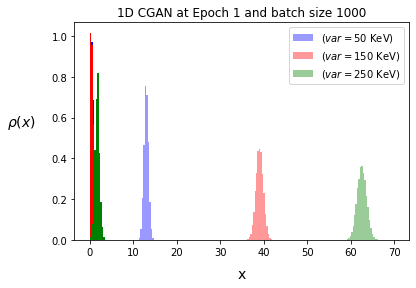

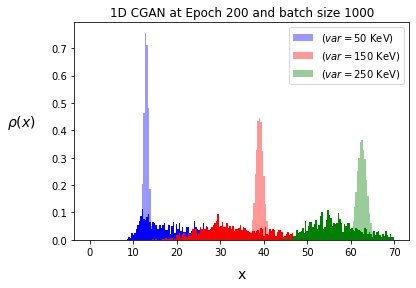

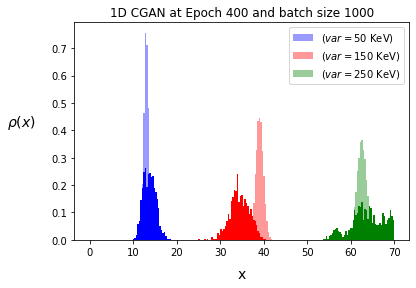

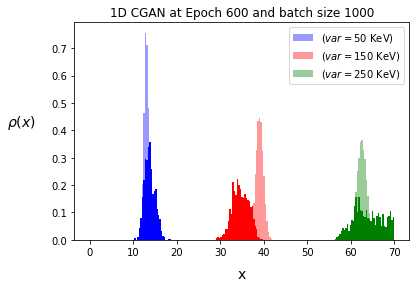

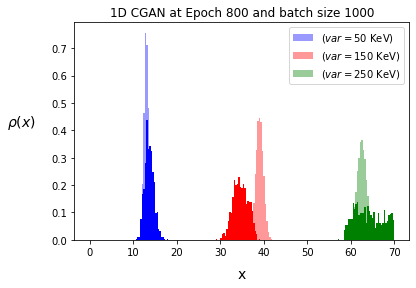

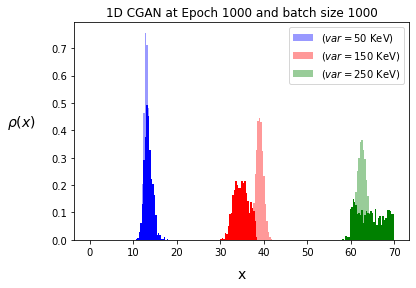

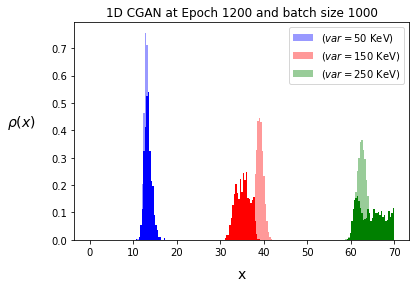

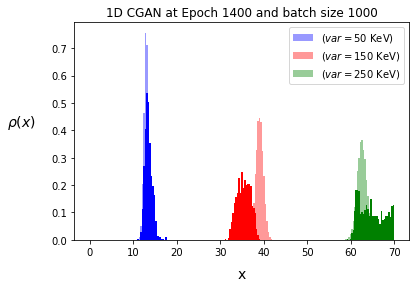

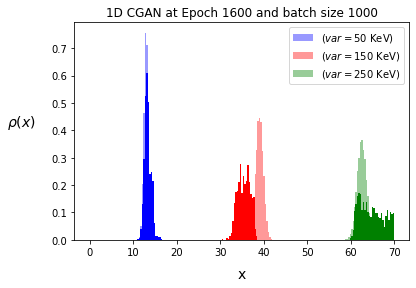

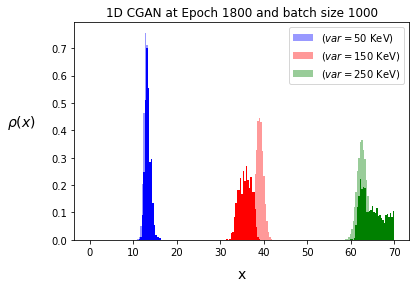

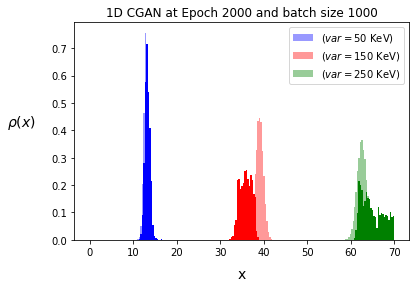

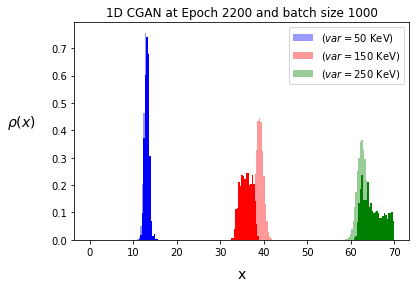

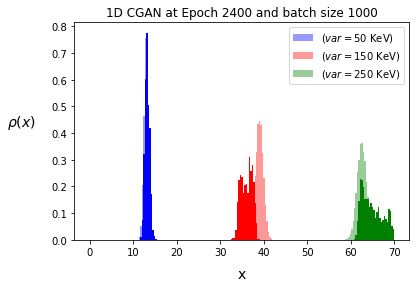

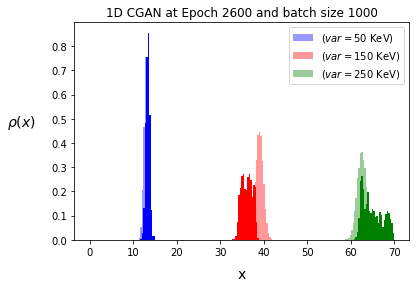

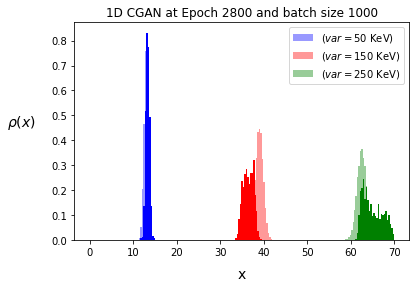

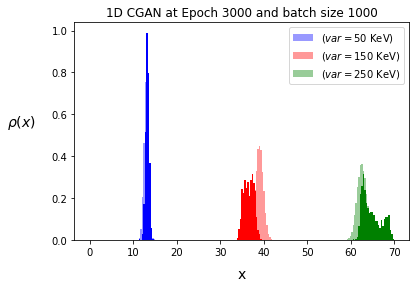

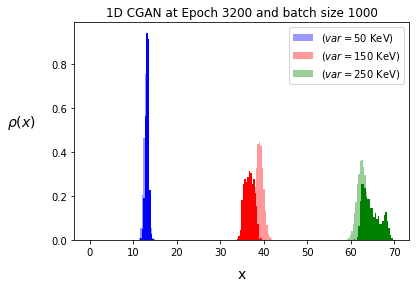

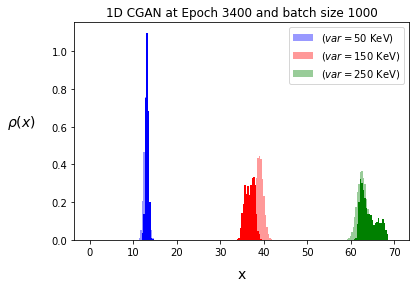

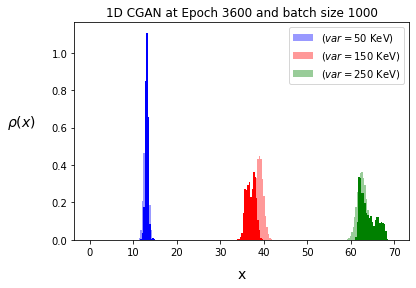

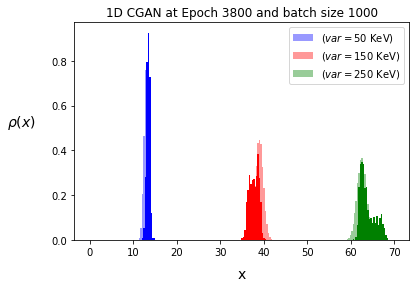

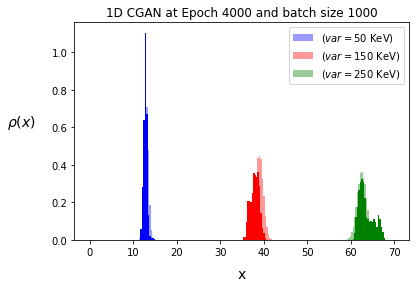

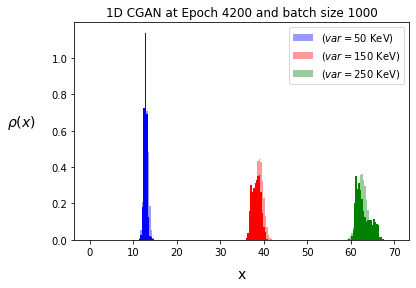

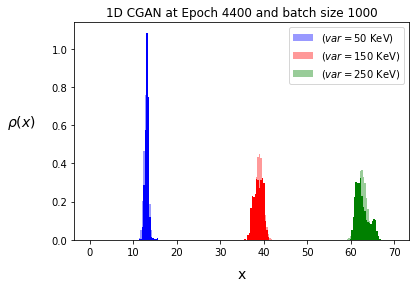

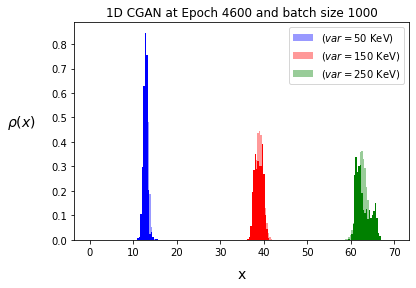

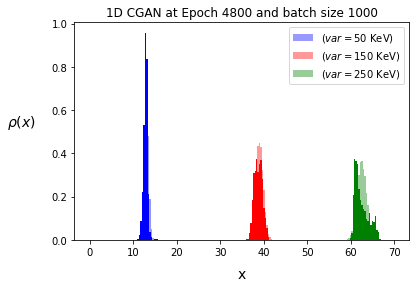

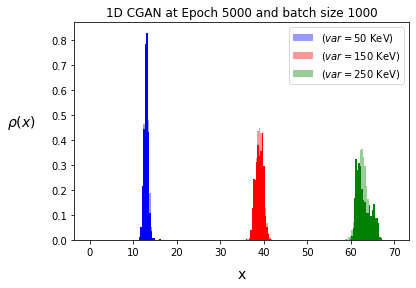

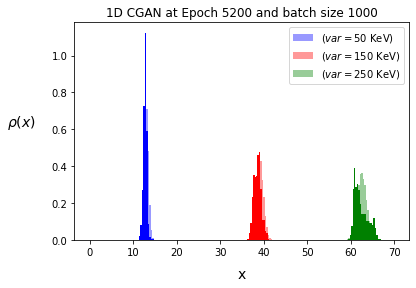

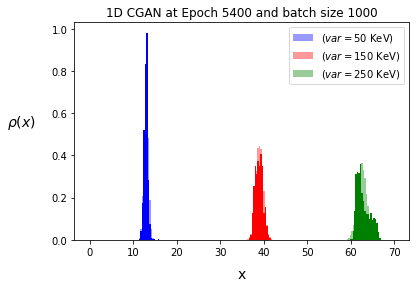

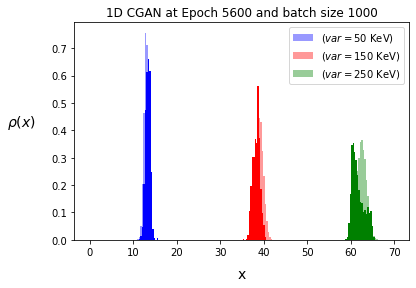

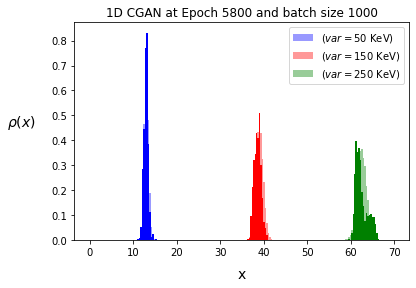

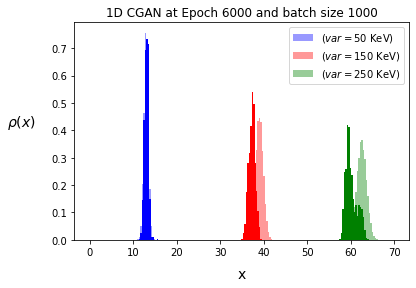

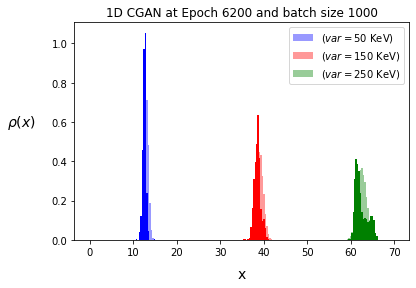

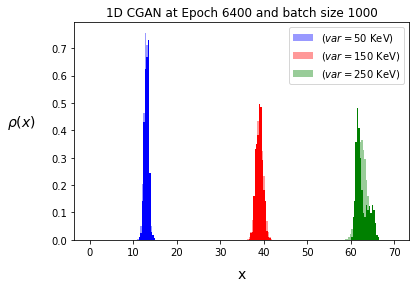

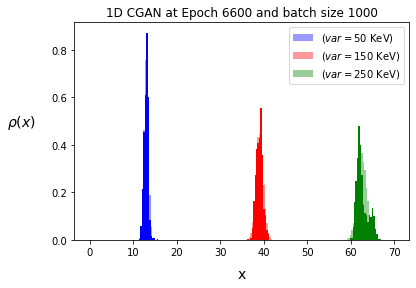

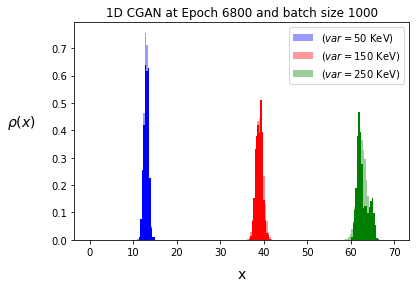

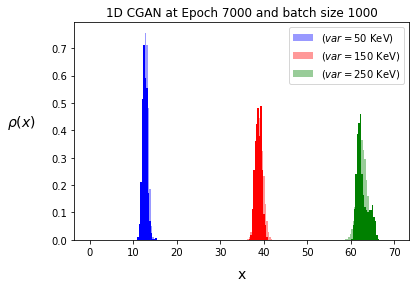

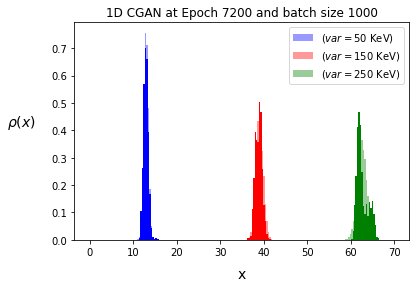

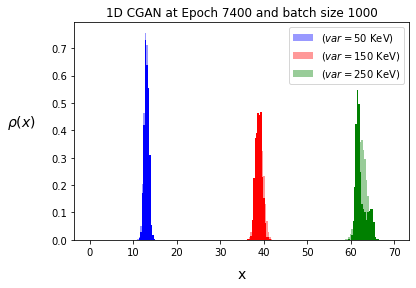

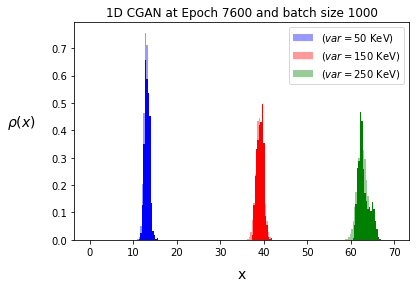

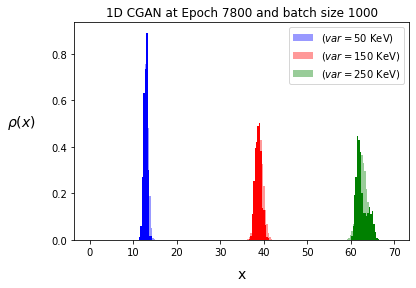

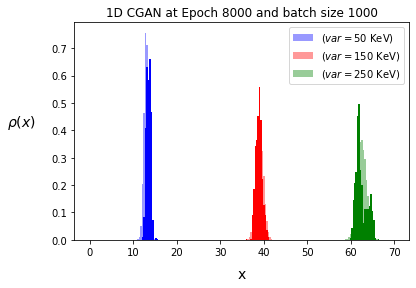

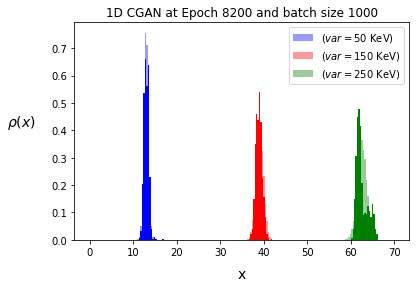

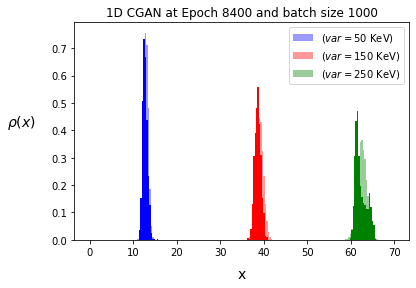

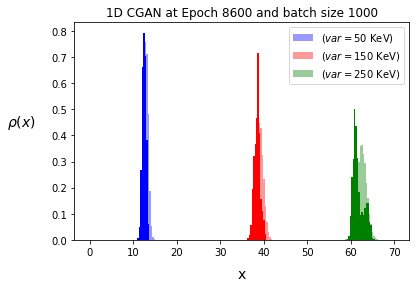

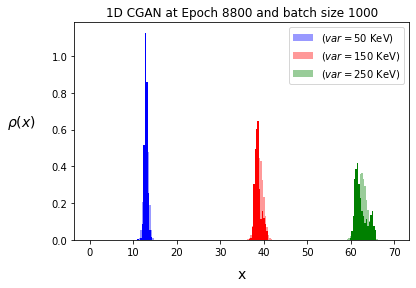

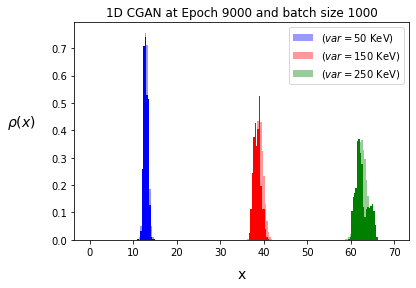

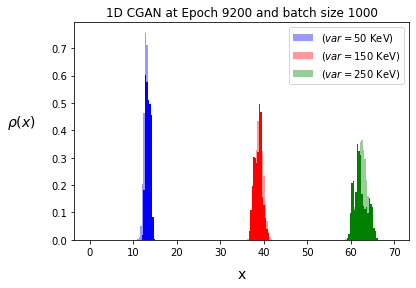

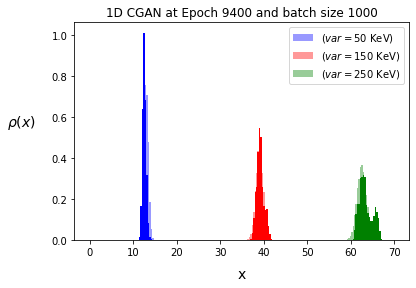

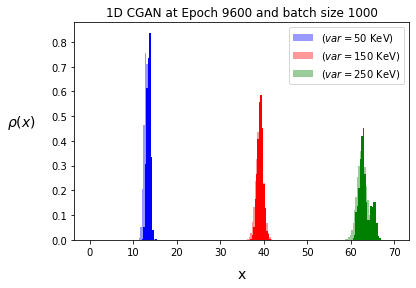

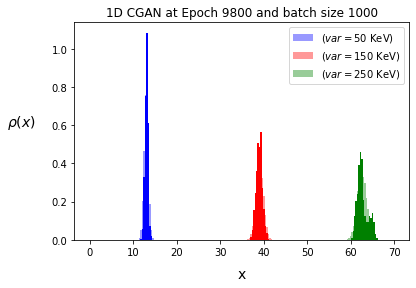

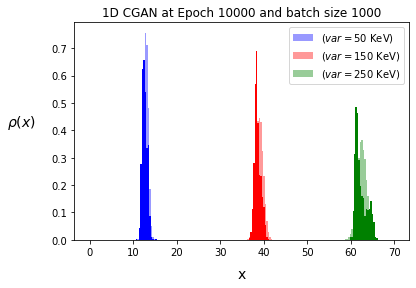

In [11]:
#  Train GAN
range_min, range_max = 0, 70
range_width = 70
plot_resolution = 200
epochs     = 10000
batch_size = 1000

real_loss = []
real_acc = []
epoch_no = []

def update_batch_size (gen_DS, e) :
    global batch_size
    #batch_size = min(max(batch_size, 100+int((e+1)/10.)), num_train)
    
def get_noise () :
    hyperparams = np.concatenate([np.full(fill_value=train_var[0], shape=(batch_size, 1)),
                                  np.full(fill_value=train_var[1], shape=(batch_size, 1)),
                                  np.full(fill_value=train_var[2], shape=(batch_size, 1))])
    return np.random.normal(size=(3*batch_size, noise_size)), hyperparams

def get_train_data () :
    batch_1 = train_DS_ene_50[np.random.randint(0, len(train_DS_ene_50), rel_batch_size*batch_size)].reshape(rel_batch_size*batch_size, 1)
    batch_2 = train_DS_ene_150[np.random.randint(0, len(train_DS_ene_150), rel_batch_size*batch_size)].reshape(rel_batch_size*batch_size, 1)
    batch_3 = train_DS_ene_250[np.random.randint(0, len(train_DS_ene_250), rel_batch_size*batch_size)].reshape(rel_batch_size*batch_size, 1)
    hyperparams = np.concatenate([np.full(fill_value=train_var[0], shape=(rel_batch_size*batch_size, 1)),
                                  np.full(fill_value=train_var[1], shape=(rel_batch_size*batch_size, 1)),
                                  np.full(fill_value=train_var[2], shape=(rel_batch_size*batch_size, 1))])
    return np.concatenate([batch_1, batch_2, batch_3]), hyperparams
  
epochs_saved = []
for e in range(epochs) :
    noise, noise_hyperparams    = get_noise()
    batch_DS, batch_hyperparams = get_train_data()
    gen_DS   = gc.predict([noise, noise_hyperparams])
    real_label  = np.array([[1., 0.] for i in range(3*rel_batch_size*batch_size)])
    fake_label  = np.array([[0., 1.] for i in range(3*batch_size)])
    train_label = np.array([[1., 0.] for i in range(3*batch_size)])
    X  = np.concatenate([batch_DS  , gen_DS    ])
    Xh = np.concatenate([batch_hyperparams  , noise_hyperparams    ])
    Y = np.concatenate([real_label, fake_label])
    W = np.concatenate([np.ones(shape=(batch_DS.shape[0],)), np.full(fill_value=rel_batch_size, shape=(gen_DS.shape[0],))])
    
    dc.trainable = True
    d_loss, d_acc = dc.train_on_batch([X, Xh], Y, sample_weight=W)
        
    noise, noise_hyperparams = get_noise()
    dc.trainable = False
    gan.train_on_batch([noise, noise_hyperparams], train_label)
    
    if e == 0 or (e+1) % 200 == 0 :
        noise, noise_hyperparams = get_noise()
        gen_DS = gc.predict([noise, noise_hyperparams])
        #plot_points_GAN(
        #            gen_DS,
        #            batch_DS,
        #            epoch=e+1, 
        #            batch_size=batch_size, 
        #            d_acc=dc.evaluate([X, Xh], Y, sample_weight=W, verbose=0)[1])
        e_50 = plt.hist(train_DS_ene_50,range = (0,70), density = True, bins = 205, alpha = 0.4, color='blue', label=r"($var="+f"{train_var[0]:.0f}"+r"~{\rm KeV}$)")
        e_150 = plt.hist(train_DS_ene_150,range = (0,70), density = True, bins = 205, alpha = 0.4, color='red', label=r"($var="+f"{train_var[1]:.0f}"+r"~{\rm KeV}$)")
        e_250 = plt.hist(train_DS_ene_250,range = (0,70), density = True, bins = 205, alpha = 0.4, color='green', label=r"($var="+f"{train_var[2]:.0f}"+r"~{\rm KeV}$)")

        gen_class_length = int(gen_DS.shape[0]/3)
        gen_data_115 = gen_DS[:gen_class_length                    ,0]
        gen_data_130 = gen_DS[gen_class_length  :2*gen_class_length,0]
        gen_data_145 = gen_DS[2*gen_class_length:3*gen_class_length,0]
        
        gen_50 = plt.hist(gen_data_115,range = (0,70), density = True, bins = 205, color='blue')
        gen_150 = plt.hist(gen_data_130,range = (0,70), density = True, bins = 205, color='red')
        gen_250 = plt.hist(gen_data_145,range = (0,70), density = True, bins = 205, color='green')

        plt.legend(loc="upper right", fontsize=10)
        plt.xlabel("x", size=14, labelpad=10)
        plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
        plt.title(f"1D CGAN at Epoch {e+1} and batch size {batch_size}")
        #plt.text(50,0.85,f"Epochs: {epochs}")
        #plt.text(50,0.75,f"Batch Size: {batch_size}")
        plt.show()
        epoch_no.append(e)
        real_loss.append(d_loss)
        real_acc.append(d_acc)

        update_batch_size(gen_DS, e)
        epochs_saved.append(e+1)

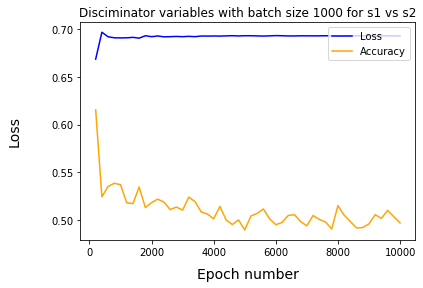

In [15]:
#del epoch_no[0]
#del real_loss[0]
#del real_acc[0]
h3 = plt.plot(epoch_no,real_loss, color = 'blue', label = "Loss")
h4 = plt.plot(epoch_no,real_acc, color = 'orange', label = "Accuracy")
plt.xlabel("Epoch number", size=14, labelpad=10)
plt.ylabel("Loss", size=14, labelpad=30, rotation="vertical")
plt.title(f"Disciminator variables with batch size {batch_size} for s1 vs s2")
plt.legend(loc="upper right", fontsize=10)
plt.show()

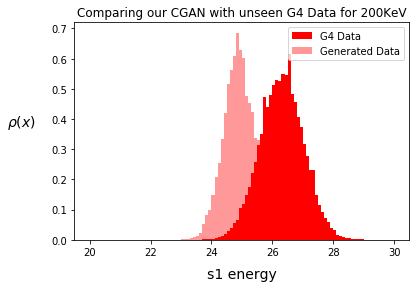

          MASS = 100
GENERATED MEAN = 25.2


In [14]:
mass = 100

hyperparams = np.full(fill_value=mass, shape=(100000, 1))
z = np.random.normal(size=(10000, noise_size))
datapoints = gc.predict([z, hyperparams])[:,0]
s1_true = plt.hist(train_DS_ene_100, density = True, range = (20,30),  bins = 100, alpha = 1, color='red', label = 'G4 Data')
s1_gen = plt.hist(datapoints, density = True, range = (20,30),  bins = 100, alpha = 0.4, color='red', label = 'Generated Data')


plt.legend(loc="upper right", fontsize=10)
plt.xlabel("s1 energy", size=14, labelpad=10)
plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
plt.title("Comparing our CGAN with unseen G4 Data for 200KeV")

#s1_diff = s1_true[0] - s1_gen[0]

#sum_s1_diff = 0
#for i in range(len(s1_diff)):
 # sum_s1_diff += abs(s1_diff[i])

#plt.text(60,0.43,f"Loss: {round(sum_s1_diff)}")

plt.show()

print(f"          MASS = {mass}")
print(f"GENERATED MEAN = {np.mean(datapoints):.1f}")